In [8]:
using LinearAlgebra, SpecialFunctions, SimplexQuad
import GaussQuadrature.legendre
function GL(m; a=0, b=1) 
    # m points Gauss-Legendre quadrature for [a, b]
    xi, wi = legendre(m)
    return map( t->((a+b)/2 + t*(b-a)/2), xi ), (b-a) * wi / 2
end
function K_quadrature(K, α, s; m=50) 
    # Creates K matrix according to m quadrature points
    # Method proposed in (Bornemann, 2009)
    x, w = GL(m; a=0, b=last(s))
    w_sqrt = sqrt.(w)
    return (w_sqrt*w_sqrt') .* map(t->K(α,s,t...), [(xi,xj) for xi in x, xj in x]) 
end

"""
Computing the Bessel Kernel
- For x=y case, see https://arxiv.org/pdf/hep-th/9304063.pdf Eq (1.2b).
- For x!=y case, see page 6 of the above paper.
- For x!=y case, alternative but identical representation in https://arxiv.org/pdf/2206.09411.pdf Eq (25)
which is ( Ja(α, √x) * √y * Ja(α-1, √y) - √x * Ja(α-1, √x) * Ja(α, √y) ) / ( 2 * (x - y) )

HEpdf  : pdf of the smallest eigenvalue, hard-edge
HE2pdf : pdf of the second smallest eigenvalue, hard-edge
"""
Ja = besselj
K_Bess(α, x, y) = x==y ? ( Ja(α, √x)^2 - Ja(α+1, √x) * Ja(α-1, √x) ) / 4 :
                                 ( Ja(α+1, √x) * √x * Ja(α, √y) - √y * Ja(α+1, √y) * Ja(α, √x) ) / ( 2 * (x - y) )
K_Bessp(α, s, x, y) = K_Bess(α, x, y) - K_Bess(α, s, x) * K_Bess(α, s, y) / K_Bess(α, s, s)
HEpdf(α, s; m=50) = K_Bess(α, s, s) * det(I-K_quadrature(K_Bessp, α, s; m=m)) 
function HE2pdf(α, s; m=50)
    K = K_quadrature(K_Bessp, α, s; m=m)
    L = (I-K)\K
    return K_Bess(α,s,s)*tr(L)/det(I+L)
end
function compute_moments(α, m; xmax=200, mint=50) 
    # Computes the first four moments of λ1, λ2
    # Mean, Variance, Skewness, Excess kurtosis
    xs_gl, ws_gl = GL(m; a=0, b=xmax)
    f1_gl, f2_gl = HEpdf.(α, xs_gl; m=mint), HE2pdf.(α, xs_gl;m=mint)
    Eλ1 = sum(f1_gl .* ws_gl .* xs_gl)
    Eλ2 = sum(f2_gl .* ws_gl .* xs_gl)
    Vλ1 = sum(f1_gl .* ws_gl .* xs_gl.^2) - Eλ1^2
    Vλ2 = sum(f2_gl .* ws_gl .* xs_gl.^2) - Eλ2^2
    σλ1, σλ2 = sqrt(Vλ1), sqrt(Vλ2)
    Sλ1 = sum(f1_gl .* ws_gl .* ((xs_gl.-Eλ1)./σλ1).^3)
    Sλ2 = sum(f2_gl .* ws_gl .* ((xs_gl.-Eλ2)./σλ2).^3)
    Kλ1 = sum(f1_gl .* ws_gl .* ((xs_gl.-Eλ1)./σλ1).^4)-3
    Kλ2 = sum(f2_gl .* ws_gl .* ((xs_gl.-Eλ2)./σλ2).^4)-3
    return [Eλ1, Vλ1, Sλ1, Kλ1], [Eλ2, Vλ2, Sλ2, Kλ2]
end

### Now some joint pdf related routines
K_Bess_λ1λ2(α, λs, x, y)   = K_Bess(α,x,y) - K_Bess.(α,x,λs)'*(K_Bess.(α,λs,λs')\K_Bess.(α,λs,y))
joint_pdf_λ1λ2(α, x; m=50) = x[1]<x[2] ? det(K_Bess.(α,x,x'))*det(I-K_quadrature(K_Bess_λ1λ2,α,x;m=m)) : 0.0
function compute_Eλ1λ2(α, m; xmax=200, mint=50)
    # Computes Eλ1λ2 using 2D quadrature
    xs_sq, ws_sq = simplexquad(m, [0.0 0; xmax xmax; 0 xmax])
    xs_grid = [xs_sq[i,:] for i in 1:size(xs_sq,1)]
    fs_sq = joint_pdf_λ1λ2.(α,xs_grid; m=mint)
    return sum(ws_sq .* fs_sq .* prod.(xs_grid)) # Eλ1λ2
end
compute_moments(0, 10; xmax=500, mint=10); # pre-compilation

In [3]:
α = 0;
@time Mλ1_0, Mλ2_0 = compute_moments(α, 50; xmax=500, mint=30)
@time Eλ1λ2_0 = compute_Eλ1λ2(α, 70; xmax=500, mint=40)
ρ_0 = (Eλ1λ2_0 - Mλ1_0[1]*Mλ2_0[1])/sqrt(Mλ1_0[2]*Mλ2_0[2])

  0.334175 seconds (5.48 M allocations: 89.847 MiB, 2.45% gc time, 1.87% compilation time)
 76.097806 seconds (1.33 G allocations: 30.183 GiB, 5.69% gc time, 6.37% compilation time)


0.3376190852244158

In [4]:
# HIGH PRECISION CONTROL 
α = 0;
@time Mλ1_0, Mλ2_0 = compute_moments(α, 100; xmax=800, mint=50)
@time Eλ1λ2_0 = compute_Eλ1λ2(α, 100; xmax=800, mint=50)
ρ_0 = (Eλ1λ2_0 - Mλ1_0[1]*Mλ2_0[1])/sqrt(Mλ1_0[2]*Mλ2_0[2])

  1.488307 seconds (30.45 M allocations: 498.227 MiB, 4.21% gc time)
222.779203 seconds (4.17 G allocations: 92.606 GiB, 5.78% gc time)


0.33761908522446027

In [6]:
# HIGH PRECISION CONTROL +
α = 0;
@time Mλ1_0, Mλ2_0 = compute_moments(α, 150; xmax=1000, mint=60)
@time Eλ1λ2_0 = compute_Eλ1λ2(α, 120; xmax=1000, mint=60)
ρ_0 = (Eλ1λ2_0 - Mλ1_0[1]*Mλ2_0[1])/sqrt(Mλ1_0[2]*Mλ2_0[2])

  3.460470 seconds (65.79 M allocations: 1.051 GiB, 4.14% gc time)
472.695576 seconds (8.65 G allocations: 191.999 GiB, 5.54% gc time)


0.33761908522455175

In [4]:
α = 1;
@time Mλ1_1, Mλ2_1 = compute_moments(α, 40; xmax=600, mint=30)
@time Eλ1λ2_1 = compute_Eλ1λ2(α, 70; xmax=600, mint=40)
ρ_1 = (Eλ1λ2_1 - Mλ1_1[1]*Mλ2_1[1])/sqrt(Mλ1_1[2]*Mλ2_1[2])

  0.278988 seconds (4.38 M allocations: 71.876 MiB, 1.21% gc time)
 76.682973 seconds (1.31 G allocations: 29.047 GiB, 3.13% gc time)


0.3917356930212259

In [7]:
# HIGH PRECISION CHECK
α = 1;
@time Mλ1_1, Mλ2_1 = compute_moments(α, 100; xmax=800, mint=50)
@time Eλ1λ2_1 = compute_Eλ1λ2(α, 100; xmax=800, mint=50)
ρ_1 = (Eλ1λ2_1 - Mλ1_1[1]*Mλ2_1[1])/sqrt(Mλ1_1[2]*Mλ2_1[2])

  1.805700 seconds (30.45 M allocations: 498.225 MiB, 1.99% gc time)
248.931300 seconds (4.17 G allocations: 92.606 GiB, 3.10% gc time)


0.3917356930214114

In [5]:
α = 2;
@time Mλ1_2, Mλ2_2 = compute_moments(α, 40; xmax=800, mint=30)
@time Eλ1λ2_2 = compute_Eλ1λ2(α, 70; xmax=800, mint=40)
ρ_2 = (Eλ1λ2_2 - Mλ1_2[1]*Mλ2_2[1])/sqrt(Mλ1_2[2]*Mλ2_2[2])

  0.286355 seconds (4.38 M allocations: 71.876 MiB, 2.56% gc time)
 83.313015 seconds (1.31 G allocations: 29.047 GiB, 2.88% gc time)


0.4171879154108391

In [8]:
# HIGH PRECISION CHECK
α = 2;
@time Mλ1_2, Mλ2_2 = compute_moments(α, 100; xmax=1000, mint=50)
@time Eλ1λ2_2 = compute_Eλ1λ2(α, 100; xmax=1000, mint=50)
ρ_2 = (Eλ1λ2_2 - Mλ1_2[1]*Mλ2_2[1])/sqrt(Mλ1_2[2]*Mλ2_2[2])

  1.829321 seconds (30.45 M allocations: 498.225 MiB, 2.33% gc time)
264.267800 seconds (4.17 G allocations: 92.606 GiB, 2.92% gc time)


0.4171879154112569

In [7]:
# HIGH PRECISION CHECK +
α = 2;
@time Mλ1_2, Mλ2_2 = compute_moments(α, 150; xmax=1400, mint=60)
@time Eλ1λ2_2 = compute_Eλ1λ2(α, 150; xmax=1400, mint=60)
ρ_2 = (Eλ1λ2_2 - Mλ1_2[1]*Mλ2_2[1])/sqrt(Mλ1_2[2]*Mλ2_2[2])

  4.904009 seconds (65.79 M allocations: 1.051 GiB, 3.20% gc time)
913.895936 seconds (13.52 G allocations: 299.998 GiB, 4.36% gc time)


0.41718791541152944

## Just having fun with spacings of various $\alpha$ values. Compare with Figure 2 of https://arxiv.org/pdf/0704.1926.pdf

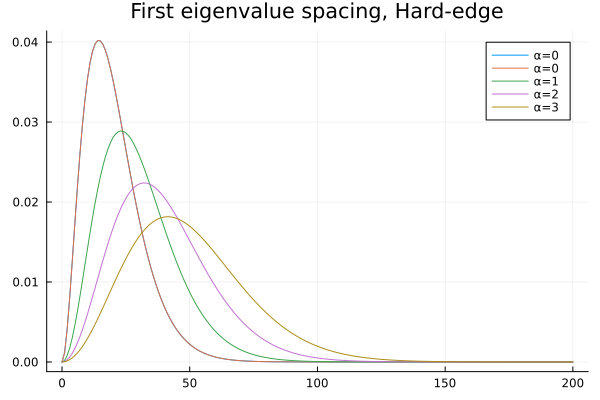

In [10]:
using Plots
function Asoft(α,dist; mint=30, mf=30, xmin=0, xmax=400)
    x, w = GL(mint; a=xmin, b=xmax)
    return sum(w.*map(t->joint_pdf_λ1λ2(α,[t,t+dist];m=mf), x))
end
t = 0:1:200
plot(t, Asoft.(0,t), label="α=0", title="First eigenvalue spacing, Hard-edge")
for i in 0:1:3
    plot!(t, Asoft.(i,t), label="α=$i")
end
plot!()